In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
from numba import njit

## Constants

In [2]:
gravity_const = 6.67430e-11   # Gravitational constant
mass_earth = 5.972e24         #Earth's mass
radius_earth = 6378000        # Earth's radius in meters

## Necessary functions

In [3]:
@njit
def grav_accel(time, pos_x, pos_y):
    """
    Computes the gravitational acceleration based on position.

    Parameters:
    time (float): The current time in the simulation.
    pos_x (float): The x-coordinate of the position.
    pos_y (float): The y-coordinate of the position.

    Returns:
    accel_x (float): The acceleration in the x-direction.
    accel_y (float): The acceleration in the y-direction.
    """
    dist_squared = pos_x**2 + pos_y**2  # square of distance from Earth's center
    accel_x = -gravity_const * mass_earth * pos_x / dist_squared**1.5  # acceleration in x-direction
    accel_y = -gravity_const * mass_earth * pos_y / dist_squared**1.5  # acceleration in y-direction
    return accel_x, accel_y

@njit
def euler_orbit(sim_time, time_step):
    """
    Solves the orbital motion using the Euler method.

    Parameters:
    sim_time (float): Total time for the simulation.
    time_step (float): Time step for the Euler method.

    Returns:
    pos_x (ndarray): Array of x-positions over time.
    pos_y (ndarray): Array of y-positions over time.
    vel_x (ndarray): Array of velocities in x-direction over time.
    vel_y (ndarray): Array of velocities in y-direction over time.
    sim_time_array (ndarray): Array of time points during the simulation.
    """
    steps = int(sim_time / time_step)
    
    # Initializing arrays for position, velocity, and time
    pos_x = np.zeros(steps)
    pos_y = np.zeros(steps)
    vel_x = np.zeros(steps)
    vel_y = np.zeros(steps)
    sim_time_array = np.zeros(steps)

    # Initial conditions
    pos_x[0] = radius_earth + 300000  # 300 km above Earth's surface at perigee
    pos_y[0] = 0
    vel_x[0] = 0  # Initial velocity in y-direction
    vel_y[0] = 9000  # Speed at perigee, tangential to the orbit
    
    # Euler integration loop
    for i in range(steps - 1):
        sim_time_array[i+1] = sim_time_array[i] + time_step
        accel_x, accel_y = grav_accel(sim_time_array[i], pos_x[i], pos_y[i])
        vel_x[i+1] = vel_x[i] + time_step * accel_x
        vel_y[i+1] = vel_y[i] + time_step * accel_y
        pos_x[i+1] = pos_x[i] + time_step * vel_x[i]
        pos_y[i+1] = pos_y[i] + time_step * vel_y[i]
        
    return pos_x, pos_y, vel_x, vel_y, sim_time_array

@njit
def orbit_dynamics(state):
    """
    Computes the dynamics of the orbit.

    Parameters:
    state (ndarray): A 1D array containing position and velocity [pos_x, pos_y, vel_x, vel_y].

    Returns:
    dynamics (ndarray): Array containing velocities and accelerations [vel_x, vel_y, accel_x, accel_y].
    """
    pos_x, pos_y, vel_x, vel_y = state
    dist_squared = pos_x**2 + pos_y**2
    accel_x = -gravity_const * mass_earth * pos_x / dist_squared**1.5
    accel_y = -gravity_const * mass_earth * pos_y / dist_squared**1.5
    return np.array([vel_x, vel_y, accel_x, accel_y], dtype=np.float64)

@njit
def rk2_orbit_solver(total_time, step_size):
    """
    Solves the orbital motion using the RK2 (Midpoint) method.

    Parameters:
    total_time (float): Total time for the simulation.
    step_size (float): Time step for the RK2 method.

    Returns:
    sim_time_array (ndarray): Array of time points during the simulation.
    pos_x (ndarray): Array of x-positions over time.
    pos_y (ndarray): Array of y-positions over time.
    vel_x (ndarray): Array of velocities in x-direction over time.
    vel_y (ndarray): Array of velocities in y-direction over time.
    """
    steps = int(total_time / step_size)
    sim_time_array = np.zeros(steps)
    pos_x = np.zeros(steps)
    pos_y = np.zeros(steps)
    vel_x = np.zeros(steps)
    vel_y = np.zeros(steps)

    # Initial conditions
    state = np.array([radius_earth + 300000, 0, 0, 9000], dtype=np.float64)

    for i in range(steps):
        sim_time_array[i] = i * step_size
        pos_x[i], pos_y[i], vel_x[i], vel_y[i] = state
        # RK2 (Midpoint) method steps
        k1 = step_size * orbit_dynamics(state)
        k2 = step_size * orbit_dynamics(state + 0.5 * k1)  # Midpoint evaluation
        state += k2  # Final update with the midpoint approximation
    
    return sim_time_array, pos_x, pos_y, vel_x, vel_y

@njit
def rk4_orbit_solver(total_time, step_size):
    """
    Solves the orbital motion using the RK4 method.

    Parameters:
    total_time (float): Total time for the simulation.
    step_size (float): Time step for the RK4 method.

    Returns:
    sim_time_array (ndarray): Array of time points during the simulation.
    pos_x (ndarray): Array of x-positions over time.
    pos_y (ndarray): Array of y-positions over time.
    vel_x (ndarray): Array of velocities in x-direction over time.
    vel_y (ndarray): Array of velocities in y-direction over time.
    """
    steps = int(total_time / step_size)
    sim_time_array = np.zeros(steps)
    pos_x = np.zeros(steps)
    pos_y = np.zeros(steps)
    vel_x = np.zeros(steps)
    vel_y = np.zeros(steps)

    # Initial conditions
    state = np.array([radius_earth + 300000, 0, 0, 9000], dtype=np.float64)

    for i in range(steps):
        sim_time_array[i] = i * step_size
        pos_x[i], pos_y[i], vel_x[i], vel_y[i] = state
        # RK4 method steps
        k1 = step_size * orbit_dynamics(state)
        k2 = step_size * orbit_dynamics(state + 0.5 * k1)
        k3 = step_size * orbit_dynamics(state + 0.5 * k2)
        k4 = step_size * orbit_dynamics(state + k3)
        state += (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    return sim_time_array, pos_x, pos_y, vel_x, vel_y

'''
def calculate_euler_time_period(euler_pos_x, euler_pos_y, euler_time):
    # Find time period based on when x-coordinate returns to perigee (initial position)
    euler_indx = 0
    initial_x = radius_earth + 300000  # initial position at perigee

    # Find the index where x-coordinate returns close to initial perigee value
    a = euler_pos_x - initial_x
    min_diff_x = np.min(np.abs(a[1:]))  # Find the minimum difference to the initial x
    for i in range(len(euler_pos_x)):
        if np.abs(a[i]) == min_diff_x:
            print(f'The x-time period (Euler) is {euler_time[i]:.2f} s at index {i}')
            euler_indx = i
            break

    # Find time period based on y-coordinate returning to zero
    euler_indy = 0
    min_diff_y = np.min(np.abs(euler_pos_y[int(len(euler_pos_y) / 2):]))  # second half to find zero-crossing
    for i in range(len(euler_pos_y)):
        if np.abs(euler_pos_y[i]) == min_diff_y:
            print(f'The y-time period (Euler) is {euler_time[i]:.2f} s at index {i}')
            euler_indy = i
            break
    
    return euler_indx, euler_indy
'''

@njit
def calculate_euler_time_period(euler_pos_x, euler_pos_y, euler_time):
    """
    Calculates the time period of an orbit using the Euler method by identifying when the object
    returns to its initial position in both x and y directions.
    
    Parameters:
    euler_pos_x : numpy array
        Array containing the x-position values during the Euler simulation.
    euler_pos_y : numpy array
        Array containing the y-position values during the Euler simulation.
    euler_time : numpy array
        Array containing the time values during the Euler simulation.
    
    Returns:
    Eu_indx : int
        Index where the x-position returns close to its initial perigee value.
    Eu_indy : int
        Index where the y-position returns close to zero after half of the orbit (y-time period).
    """
    initial_x = radius_earth + 300000
    # Initializing index variables
    Eu_indx = 0
    Eu_indy = 0

    # Finding when x crosses the initial x value
    for i in range(1, len(euler_pos_x)):
        # Detect the point where the orbit crosses the initial x-value from above to below or vice versa
        if (euler_pos_x[i-1] - initial_x) * (euler_pos_x[i] - initial_x) < 0:
            Eu_indx = i
            break

    # Finding the minimum y value after half the orbit (y-time period)
    half_orbit_idx = int(len(euler_pos_y) / 2)
    min_y_val = np.abs(euler_pos_y[half_orbit_idx])
    Eu_indy = half_orbit_idx

    for i in range(half_orbit_idx, len(euler_pos_y)):
        if np.abs(euler_pos_y[i]) < min_y_val:
            min_y_val = np.abs(euler_pos_y[i])
            Eu_indy = i

    # Returning both time periods (indices)
    return Eu_indx, Eu_indy

@njit
def calculate_rk2_time_period(rk2_pos_x, rk2_pos_y, rk2_time):
    """
    Calculates the time period of an orbit using the RK2 method by identifying when the object
    returns to its initial position in both x and y directions.
    
    Parameters:
    rk2_pos_x : numpy array
        Array containing the x-position values during the RK2 simulation.
    rk2_pos_y : numpy array
        Array containing the y-position values during the RK2 simulation.
    rk2_time : numpy array
        Array containing the time values during the RK2 simulation.
    
    Returns:
    rk2_indx : int
        Index where the x-position returns close to its initial perigee value.
    rk2_indy : int
        Index where the y-position returns close to zero after half of the orbit (y-time period).
    """
    initial_x = radius_earth + 300000
    # Initializing index variables
    rk2_indx = 0
    rk2_indy = 0

    # Finding the index where x-coordinate returns close to initial perigee value
    a = rk2_pos_x - initial_x
    min_diff_x = np.min(np.abs(a[1:]))  # Finding the minimum difference to the initial x
    for i in range(len(rk2_pos_x)):
        if np.abs(a[i]) == min_diff_x:
            rk2_indx = i
            break

    # Finding time period based on y-coordinate returning to zero (second half)
    min_diff_y = np.min(np.abs(rk2_pos_y[int(len(rk2_pos_y) / 2):]))  # Finding the minimum y after half orbit
    for i in range(len(rk2_pos_y)):
        if np.abs(rk2_pos_y[i]) == min_diff_y:
            rk2_indy = i
            break
    
    return rk2_indx, rk2_indy

@njit
def calculate_rk4_time_period(rk4_pos_x, rk4_pos_y, rk4_time):
    """
    Calculates the time period of an orbit using the RK4 method by identifying when the object
    returns to its initial position in both x and y directions.
    
    Parameters:
    rk4_pos_x : numpy array
        Array containing the x-position values during the RK4 simulation.
    rk4_pos_y : numpy array
        Array containing the y-position values during the RK4 simulation.
    rk4_time : numpy array
        Array containing the time values during the RK4 simulation.
    
    Returns:
    rk4_indx : int
        Index where the x-position returns close to its initial perigee value.
    rk4_indy : int
        Index where the y-position returns close to zero after half of the orbit (y-time period).
    """
    initial_x = radius_earth + 300000
    # Initializing index variables
    rk4_indx = 0
    rk4_indy = 0

    # Finding the index where x-coordinate returns close to initial perigee value
    a = rk4_pos_x - initial_x
    min_diff_x = np.min(np.abs(a[1:]))  # Finding the minimum difference to the initial x
    for i in range(len(rk4_pos_x)):
        if np.abs(a[i]) == min_diff_x:
            rk4_indx = i
            break

    # Finding time period based on y-coordinate returning to zero (second half)
    min_diff_y = np.min(np.abs(rk4_pos_y[int(len(rk4_pos_y) / 2):]))  # Finding the minimum y after half orbit
    for i in range(len(rk4_pos_y)):
        if np.abs(rk4_pos_y[i]) == min_diff_y:
            rk4_indy = i
            break
    
    return rk4_indx, rk4_indy


@njit
def calc_distance(pos_x, pos_y):
    """
    Calculates the radial distance from Earth's center.

    Parameters:
    pos_x (ndarray): Array of x-positions.
    pos_y (ndarray): Array of y-positions.

    Returns:
    distance (ndarray): Radial distance at each time step.
    """
    return np.sqrt(pos_x**2 + pos_y**2)

@njit
def calc_energy(pos_x, pos_y, vel_x, vel_y):
    """
    Calculates total mechanical energy (kinetic + potential).

    Parameters:
    pos_x (ndarray): Array of x-positions.
    pos_y (ndarray): Array of y-positions.
    vel_x (ndarray): Array of velocities in x-direction.
    vel_y (ndarray): Array of velocities in y-direction.

    Returns:
    total_energy (ndarray): Total energy at each time step.
    """
    dist = np.sqrt(pos_x**2 + pos_y**2)
    kinetic_energy = 0.5 * (vel_x**2 + vel_y**2)
    potential_energy = -gravity_const * mass_earth / dist
    return kinetic_energy + potential_energy

@njit
def calc_angular_momentum(pos_x, pos_y, vel_x, vel_y):
    """
    Calculates angular momentum.

    Parameters:
    pos_x (ndarray): Array of x-positions.
    pos_y (ndarray): Array of y-positions.
    vel_x (ndarray): Array of velocities in x-direction.
    vel_y (ndarray): Array of velocities in y-direction.

    Returns:
    angular_momentum (ndarray): Angular momentum at each time step.
    """
    return pos_x * vel_y - pos_y * vel_x 

@njit
def calc_percentage_change(initial, current):
    """
    Calculates percentage change between initial and current values.

    Parameters:
    initial (float): Initial value.
    current (float): Current value.

    Returns:
    percentage_change (float): Percentage change.
    """
    return np.abs((current - initial) / initial) * 100

@njit
def energy_and_angular_momentum_loss_calc(pos_x, pos_y, vel_x, vel_y):
    """
    Calculates percentage loss in energy and angular momentum, and returns the initial and final values.

    Parameters:
    pos_x (ndarray): Array of x-positions.
    pos_y (ndarray): Array of y-positions.
    vel_x (ndarray): Array of velocities in x-direction.
    vel_y (ndarray): Array of velocities in y-direction.

    Returns:
    energy_loss (ndarray): Percentage energy loss at each time step.
    angular_momentum_loss (ndarray): Percentage angular momentum loss at each time step.
    initial_energy (float): Initial total energy.
    final_energy (float): Final total energy.
    initial_ang_momentum (float): Initial angular momentum.
    final_ang_momentum (float): Final angular momentum.
    """
    total_energy = calc_energy(pos_x, pos_y, vel_x, vel_y)
    initial_energy = total_energy[0]
    final_energy = total_energy[-1]
    
    angular_momentum = calc_angular_momentum(pos_x, pos_y, vel_x, vel_y)
    initial_ang_momentum = angular_momentum[0]
    final_ang_momentum = angular_momentum[-1]
    
    energy_loss = np.zeros(len(pos_x))
    angular_momentum_loss = np.zeros(len(pos_x))
    
    for i in range(len(pos_x)):
        energy_loss[i] = calc_percentage_change(initial_energy, total_energy[i])
        angular_momentum_loss[i] = calc_percentage_change(initial_ang_momentum, angular_momentum[i])
    
    return energy_loss, angular_momentum_loss, initial_energy, final_energy, initial_ang_momentum, final_ang_momentum

# Euler Method

## For One Orbit

#### Simulation parameters

In [4]:
total_time = 10544  # simulation time for one orbit in seconds
time_step = 0.1     # time step

#### Integration

In [5]:
%%time
euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y, euler_time = euler_orbit(total_time, time_step)

CPU times: user 402 ms, sys: 51.6 ms, total: 454 ms
Wall time: 535 ms


#### Perigee Verification and Apogee Calculation

In [6]:
%%time
euler_dist = calc_distance(euler_pos_x, euler_pos_y)

euler_apogee_idx = np.argmax(euler_dist)
euler_perigee_idx = np.argmin(euler_dist)

euler_apogee = euler_dist[euler_apogee_idx] - radius_earth
euler_perigee = euler_dist[euler_perigee_idx] - radius_earth

print(f'Apogee (Euler method): {euler_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (Euler method): {euler_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (Euler method): 7727.20 km above Earth's surface
Perigee (Euler method): 300.00 km above Earth's surface
CPU times: user 199 ms, sys: 4.94 ms, total: 203 ms
Wall time: 205 ms


#### Orbital Period Calculation

In [7]:
%%time
euler_indx, euler_indy = calculate_euler_time_period(euler_pos_x, euler_pos_y, euler_time)

print(f'The x-time period is approximately {euler_time[euler_indx]:.2f} s with index {euler_indx}')
print(f'The y-time period is approximately {euler_time[euler_indy]:.2f} s with index {euler_indy}')

The x-time period is approximately 10511.20 s with index 105112
The y-time period is approximately 10543.90 s with index 105439
CPU times: user 72 ms, sys: 126 µs, total: 72.1 ms
Wall time: 71.9 ms


When the original function for calculating the time period using the Euler method was applied (now commented out in the functions section), the x time period was incorrectly calculated as zero. This occurred because the Euler method did not accurately resolve the return to the initial perigee position along the x-axis. This issue was not observed in the RK2 and RK4 methods, where similar values for both x and y time periods were obtained. The Euler method, being less accurate than RK4, tends to accumulate positional errors over time, making it difficult to detect when the orbit returns to its original x-position.

Initially, the object started with velocity only in the y-direction. In an elliptical orbit, numerical inaccuracies in the Euler method could prevent the object from returning exactly to the same x-position. To account for this, the criteria for identifying the x time period were adjusted. Rather than relying on the exact return to the initial x-value, the method now detects when the object crosses the x-axis, using a sign change in the x-values. This approach is more robust and suitable for handling the numerical drift inherent in the Euler method.

#### Plotting the Orbit

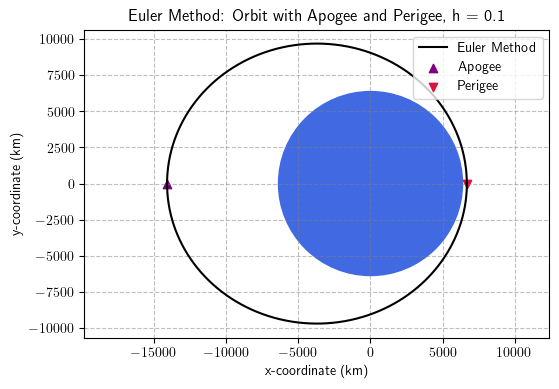

CPU times: user 284 ms, sys: 25.5 ms, total: 310 ms
Wall time: 428 ms


In [8]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.plot(euler_pos_x / 1000, euler_pos_y / 1000, lw=1.5, label='Euler Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(euler_pos_x[euler_apogee_idx] / 1000, euler_pos_y[euler_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(euler_pos_x[euler_perigee_idx] / 1000, euler_pos_y[euler_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('Euler Method: Orbit with Apogee and Perigee, h = 0.1')
plt.axis('equal')
plt.savefig('Euler Method: Orbit with Apogee and Perigee, h = 0.1.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [9]:
%%time
euler_energy_loss, euler_ang_mom_loss, euler_initial_energy, euler_final_energy, euler_initial_ang_mom, euler_final_ang_mom = energy_and_angular_momentum_loss_calc(
    euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (Euler): {euler_initial_energy:.4e}')
print(f'Final Total Energy (Euler): {euler_final_energy:.4e}')
print(f'Percentage Energy Loss (Euler): {euler_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (Euler): {euler_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (Euler): {euler_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (Euler): {euler_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (Euler): -1.9187e+07
Final Total Energy (Euler): -1.9165e+07
Percentage Energy Loss (Euler): 1.1197e-01%
Initial Angular Momentum (Euler): 6.0102e+10
Final Angular Momentum (Euler): 6.0130e+10
Percentage Angular Momentum Loss (Euler): 4.5953e-02%

CPU times: user 544 ms, sys: 10.6 ms, total: 554 ms
Wall time: 557 ms


#### Simulation parameters

In [10]:
total_time = 10544  # simulation time for one orbit in seconds
time_step =  1      # time step

#### Integration

In [11]:
%%time
euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y, euler_time = euler_orbit(total_time, time_step)

CPU times: user 111 ms, sys: 25 µs, total: 111 ms
Wall time: 111 ms


#### Perigee Verification and Apogee Calculation

In [12]:
%%time
euler_dist = calc_distance(euler_pos_x, euler_pos_y)

euler_apogee_idx = np.argmax(euler_dist)
euler_perigee_idx = np.argmin(euler_dist)

euler_apogee = euler_dist[euler_apogee_idx] - radius_earth
euler_perigee = euler_dist[euler_perigee_idx] - radius_earth

print(f'Apogee (Euler method): {euler_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (Euler method): {euler_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (Euler method): 7810.24 km above Earth's surface
Perigee (Euler method): 300.00 km above Earth's surface
CPU times: user 386 µs, sys: 34 µs, total: 420 µs
Wall time: 436 µs


#### Orbital Period Calculation

In [13]:
%%time
euler_indx, euler_indy = calculate_euler_time_period(euler_pos_x, euler_pos_y, euler_time)

print(f'The x-time period is approximately {euler_time[euler_indx]:.2f} s with index {euler_indx}')
print(f'The y-time period is approximately {euler_time[euler_indy]:.2f} s with index {euler_indy}')

The x-time period is approximately 10520.00 s with index 10520
The y-time period is approximately 5291.00 s with index 5291
CPU times: user 72 µs, sys: 6 µs, total: 78 µs
Wall time: 77.2 µs


#### Plotting the Orbit

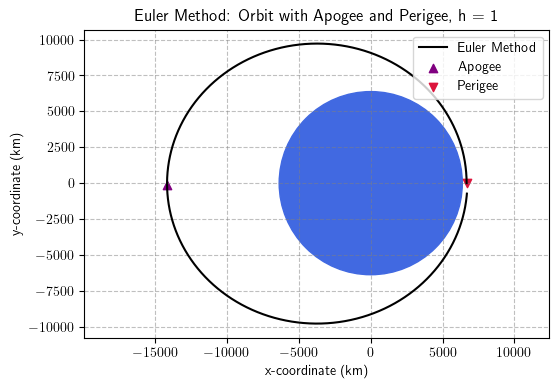

CPU times: user 199 ms, sys: 5.99 ms, total: 205 ms
Wall time: 211 ms


In [14]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.plot(euler_pos_x / 1000, euler_pos_y / 1000, lw=1.5, label='Euler Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(euler_pos_x[euler_apogee_idx] / 1000, euler_pos_y[euler_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(euler_pos_x[euler_perigee_idx] / 1000, euler_pos_y[euler_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('Euler Method: Orbit with Apogee and Perigee, h = 1')
plt.axis('equal')
plt.savefig('Euler Method: Orbit with Apogee and Perigee, h = 1.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [15]:
%%time
euler_energy_loss, euler_ang_mom_loss, euler_initial_energy, euler_final_energy, euler_initial_ang_mom, euler_final_ang_mom = energy_and_angular_momentum_loss_calc(
    euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (Euler): {euler_initial_energy:.4e}')
print(f'Final Total Energy (Euler): {euler_final_energy:.4e}')
print(f'Percentage Energy Loss (Euler): {euler_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (Euler): {euler_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (Euler): {euler_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (Euler): {euler_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (Euler): -1.9187e+07
Final Total Energy (Euler): -1.8982e+07
Percentage Energy Loss (Euler): 1.0702e+00%
Initial Angular Momentum (Euler): 6.0102e+10
Final Angular Momentum (Euler): 6.0371e+10
Percentage Angular Momentum Loss (Euler): 4.4701e-01%

CPU times: user 459 µs, sys: 0 ns, total: 459 µs
Wall time: 435 µs


#### Simulation parameters

In [16]:
total_time = 10544  # simulation time for one orbit in seconds
time_step =  10     # time step

#### Integration

In [17]:
%%time
euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y, euler_time = euler_orbit(total_time, time_step)

CPU times: user 149 µs, sys: 0 ns, total: 149 µs
Wall time: 155 µs


#### Perigee Verification and Apogee Calculation

In [18]:
%%time
euler_dist = calc_distance(euler_pos_x, euler_pos_y)

euler_apogee_idx = np.argmax(euler_dist)
euler_perigee_idx = np.argmin(euler_dist)

euler_apogee = euler_dist[euler_apogee_idx] - radius_earth
euler_perigee = euler_dist[euler_perigee_idx] - radius_earth

print(f'Apogee (Euler method): {euler_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (Euler method): {euler_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (Euler method): 8678.13 km above Earth's surface
Perigee (Euler method): 300.00 km above Earth's surface
CPU times: user 305 µs, sys: 0 ns, total: 305 µs
Wall time: 261 µs


#### Orbital Period Calculation

In [19]:
%%time
euler_indx, euler_indy = calculate_euler_time_period(euler_pos_x, euler_pos_y, euler_time)

print(f'The x-time period is approximately {euler_time[euler_indx]:.2f} s with index {euler_indx}')
print(f'The y-time period is approximately {euler_time[euler_indy]:.2f} s with index {euler_indy}')

The x-time period is approximately 0.00 s with index 0
The y-time period is approximately 5500.00 s with index 550
CPU times: user 77 µs, sys: 6 µs, total: 83 µs
Wall time: 85.4 µs


#### Plotting the Orbit

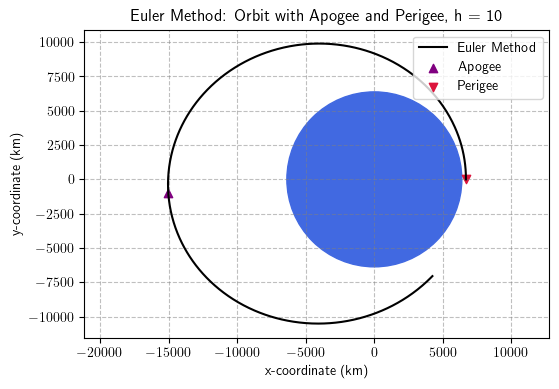

CPU times: user 203 ms, sys: 4.14 ms, total: 207 ms
Wall time: 215 ms


In [20]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.plot(euler_pos_x / 1000, euler_pos_y / 1000, lw=1.5, label='Euler Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(euler_pos_x[euler_apogee_idx] / 1000, euler_pos_y[euler_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(euler_pos_x[euler_perigee_idx] / 1000, euler_pos_y[euler_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('Euler Method: Orbit with Apogee and Perigee, h = 10')
plt.axis('equal')
plt.savefig('Euler Method: Orbit with Apogee and Perigee, h = 10.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [21]:
%%time
euler_energy_loss, euler_ang_mom_loss, euler_initial_energy, euler_final_energy, euler_initial_ang_mom, euler_final_ang_mom = energy_and_angular_momentum_loss_calc(
    euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (Euler): {euler_initial_energy:.4e}')
print(f'Final Total Energy (Euler): {euler_final_energy:.4e}')
print(f'Percentage Energy Loss (Euler): {euler_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (Euler): {euler_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (Euler): {euler_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (Euler): {euler_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (Euler): -1.9187e+07
Final Total Energy (Euler): -1.7774e+07
Percentage Energy Loss (Euler): 7.3643e+00%
Initial Angular Momentum (Euler): 6.0102e+10
Final Angular Momentum (Euler): 6.2200e+10
Percentage Angular Momentum Loss (Euler): 3.4902e+00%

CPU times: user 108 µs, sys: 9 µs, total: 117 µs
Wall time: 95.8 µs


## For 10000 Orbits

#### Simulation parameters

In [22]:
total_time = 10544*10000  # simulation time for one orbit in seconds
time_step =  1            # time step (kernel is dying with h=0.1)

#### Integration

In [23]:
%%time
euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y, euler_time = euler_orbit(total_time, time_step)

CPU times: user 2.18 s, sys: 928 ms, total: 3.11 s
Wall time: 3.08 s


#### Perigee Verification and Apogee Calculation

In [24]:
%%time
euler_dist = calc_distance(euler_pos_x, euler_pos_y)

euler_apogee_idx = np.argmax(euler_dist)
euler_perigee_idx = np.argmin(euler_dist)

euler_apogee = euler_dist[euler_apogee_idx] - radius_earth
euler_perigee = euler_dist[euler_perigee_idx] - radius_earth

print(f'Apogee (Euler method): {euler_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (Euler method): {euler_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (Euler method): 588844.02 km above Earth's surface
Perigee (Euler method): 300.00 km above Earth's surface
CPU times: user 186 ms, sys: 153 ms, total: 338 ms
Wall time: 336 ms


#### Orbital Period Calculation

In [25]:
%%time
euler_indx, euler_indy = calculate_euler_time_period(euler_pos_x, euler_pos_y, euler_time)

print(f'The x-time period is approximately {euler_time[euler_indx]:.2f} s with index {euler_indx}')
print(f'The y-time period is approximately {euler_time[euler_indy]:.2f} s with index {euler_indy}')

The x-time period is approximately 10520.00 s with index 10520
The y-time period is approximately 75590140.00 s with index 75590140
CPU times: user 52.3 ms, sys: 501 µs, total: 52.8 ms
Wall time: 52.3 ms


#### Plotting the Orbit

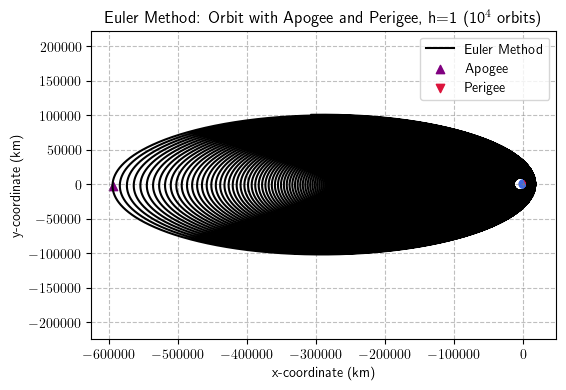

CPU times: user 309 ms, sys: 9 ms, total: 318 ms
Wall time: 331 ms


In [26]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)

# Downsampling the position data (every 1000th point)
N = 1000  # Downsampling factor

# Plotting the downsampled orbit
plt.plot(euler_pos_x[::N] / 1000, euler_pos_y[::N] / 1000, lw=1.5, label='Euler Method', c='k')
# Adding the Earth representation
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
# Plotting apogee and perigee
plt.scatter(euler_pos_x[euler_apogee_idx] / 1000, euler_pos_y[euler_apogee_idx] / 1000, 
            c='purple', label='Apogee', marker="^")
plt.scatter(euler_pos_x[euler_perigee_idx] / 1000, euler_pos_y[euler_perigee_idx] / 1000, 
            c='crimson', label='Perigee', marker="v")
# Labels and title
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('Euler Method: Orbit with Apogee and Perigee, h=1 (10$^4$ orbits)')
plt.axis('equal')
plt.savefig('Euler Method: Orbit with Apogee and Perigee, h=1 (10$^4$ orbits).pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [27]:
%%time
euler_energy_loss, euler_ang_mom_loss, euler_initial_energy, euler_final_energy, euler_initial_ang_mom, euler_final_ang_mom = energy_and_angular_momentum_loss_calc(
    euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (Euler): {euler_initial_energy:.4e}')
print(f'Final Total Energy (Euler): {euler_final_energy:.4e}')
print(f'Percentage Energy Loss (Euler): {euler_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (Euler): {euler_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (Euler): {euler_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (Euler): {euler_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (Euler): -1.9187e+07
Final Total Energy (Euler): -6.3959e+05
Percentage Energy Loss (Euler): 9.6667e+01%
Initial Angular Momentum (Euler): 6.0102e+10
Final Angular Momentum (Euler): 1.1501e+11
Percentage Angular Momentum Loss (Euler): 9.1359e+01%

CPU times: user 1.2 s, sys: 1.56 s, total: 2.77 s
Wall time: 2.79 s


#### Simulation parameters

In [35]:
total_time = 10544*10000  # simulation time for one orbit in seconds
time_step =  10           # time step (kernel is dying with h=0.1)

#### Integration

In [36]:
%%time
euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y, euler_time = euler_orbit(total_time, time_step)

CPU times: user 350 ms, sys: 58.1 ms, total: 408 ms
Wall time: 407 ms


#### Perigee Verification and Apogee Calculation

In [30]:
%%time
euler_dist = calc_distance(euler_pos_x, euler_pos_y)

euler_apogee_idx = np.argmax(euler_dist)
euler_perigee_idx = np.argmin(euler_dist)

euler_apogee = euler_dist[euler_apogee_idx] - radius_earth
euler_perigee = euler_dist[euler_perigee_idx] - radius_earth

print(f'Apogee (Euler method): {euler_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (Euler method): {euler_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (Euler method): 15075670.94 km above Earth's surface
Perigee (Euler method): 300.00 km above Earth's surface
CPU times: user 20.4 ms, sys: 43.4 ms, total: 63.9 ms
Wall time: 68.5 ms


#### Orbital Period Calculation

In [31]:
%%time
euler_indx, euler_indy = calculate_euler_time_period(euler_pos_x, euler_pos_y, euler_time)

print(f'The x-time period is approximately {euler_time[euler_indx]:.2f} s with index {euler_indx}')
print(f'The y-time period is approximately {euler_time[euler_indy]:.2f} s with index {euler_indy}')

The x-time period is approximately 11110.00 s with index 1111
The y-time period is approximately 64639430.00 s with index 6463943
CPU times: user 5.87 ms, sys: 382 µs, total: 6.25 ms
Wall time: 6.12 ms


#### Plotting the Orbit

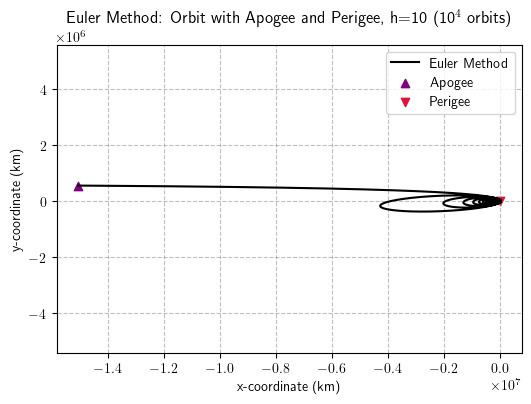

CPU times: user 226 ms, sys: 32.2 ms, total: 258 ms
Wall time: 482 ms


In [32]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)

# Downsampling the position data (every 1000th point)
N = 1000  # Downsampling factor

# Plotting the downsampled orbit
plt.plot(euler_pos_x[::N] / 1000, euler_pos_y[::N] / 1000, lw=1.5, label='Euler Method', c='k')
# Adding the Earth representation
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
# Plotting apogee and perigee
plt.scatter(euler_pos_x[euler_apogee_idx] / 1000, euler_pos_y[euler_apogee_idx] / 1000, 
            c='purple', label='Apogee', marker="^")
plt.scatter(euler_pos_x[euler_perigee_idx] / 1000, euler_pos_y[euler_perigee_idx] / 1000, 
            c='crimson', label='Perigee', marker="v")
# Labels and title
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('Euler Method: Orbit with Apogee and Perigee, h=10 (10$^4$ orbits)')
plt.axis('equal')
plt.savefig('Euler Method: Orbit with Apogee and Perigee, h=10 (10$^4$ orbits).pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [37]:
%%time
euler_energy_loss, euler_ang_mom_loss, euler_initial_energy, euler_final_energy, euler_initial_ang_mom, euler_final_ang_mom = energy_and_angular_momentum_loss_calc(
    euler_pos_x, euler_pos_y, euler_vel_x, euler_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (Euler): {euler_initial_energy:.4e}')
print(f'Final Total Energy (Euler): {euler_final_energy:.4e}')
print(f'Percentage Energy Loss (Euler): {euler_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (Euler): {euler_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (Euler): {euler_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (Euler): {euler_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (Euler): -1.9187e+07
Final Total Energy (Euler): 6.8690e+03
Percentage Energy Loss (Euler): 1.0004e+02%
Initial Angular Momentum (Euler): 6.0102e+10
Final Angular Momentum (Euler): 1.1934e+11
Percentage Angular Momentum Loss (Euler): 9.8566e+01%

CPU times: user 90.1 ms, sys: 127 ms, total: 218 ms
Wall time: 216 ms


# RK2 Method

## For One Orbit

#### Simulation parameters

In [4]:
total_time = 10536  # simulation time for one orbit in seconds
time_step = 0.1     # time step

#### Integration

In [5]:
%%time
rk2_time, rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y = rk2_orbit_solver(total_time, time_step)

CPU times: user 636 ms, sys: 57.5 ms, total: 693 ms
Wall time: 763 ms


#### Perigee Verification and Apogee Calculation

In [6]:
%%time
rk2_dist = calc_distance(rk2_pos_x, rk2_pos_y)

rk2_apogee_idx = np.argmax(rk2_dist)
rk2_perigee_idx = np.argmin(rk2_dist)

rk2_apogee = rk2_dist[rk2_apogee_idx] - radius_earth
rk2_perigee = rk2_dist[rk2_perigee_idx] - radius_earth

print(f'Apogee (RK2 Method): {rk2_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK2 Method): {rk2_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK2 Method): 7718.02 km above Earth's surface
Perigee (RK2 Method): 300.00 km above Earth's surface
CPU times: user 117 ms, sys: 5.02 ms, total: 122 ms
Wall time: 123 ms


#### Orbital Period Calculation

In [7]:
%%time
rk2_indx, rk2_indy = calculate_rk2_time_period(rk2_pos_x, rk2_pos_y, rk2_time)

print(f'The x-time period (RK2) is approximately {rk2_time[rk2_indx]:.2f} s with index {rk2_indx}')
print(f'The y-time period (RK2) is approximately {rk2_time[rk2_indy]:.2f} s with index {rk2_indy}')

The x-time period (RK2) is approximately 10535.40 s with index 105354
The y-time period (RK2) is approximately 10535.40 s with index 105354
CPU times: user 355 ms, sys: 13 ms, total: 368 ms
Wall time: 369 ms


#### Plotting the Orbit

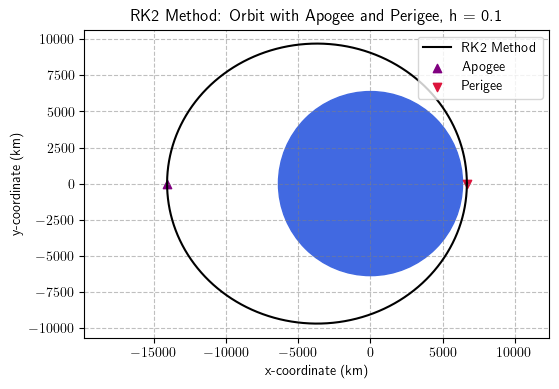

CPU times: user 343 ms, sys: 25 ms, total: 368 ms
Wall time: 495 ms


In [8]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(rk2_pos_x / 1000, rk2_pos_y / 1000, lw=1.5, label='RK2 Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(rk2_pos_x[rk2_apogee_idx] / 1000, rk2_pos_y[rk2_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(rk2_pos_x[rk2_perigee_idx] / 1000, rk2_pos_y[rk2_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK2 Method: Orbit with Apogee and Perigee, h = 0.1')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.axis('equal')
plt.savefig('RK2 Method: Orbit with Apogee and Perigee, h = 0.1.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [9]:
%%time
rk2_energy_loss, rk2_ang_mom_loss, rk2_initial_energy, rk2_final_energy, rk2_initial_ang_mom, rk2_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK2): {rk2_initial_energy:.4e}')
print(f'Final Total Energy (RK2): {rk2_final_energy:.4e}')
print(f'Percentage Energy Loss (RK2): {rk2_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK2): {rk2_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK2): {rk2_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK2): {rk2_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK2): -1.9187e+07
Final Total Energy (RK2): -1.9187e+07
Percentage Energy Loss (RK2): 1.3102e-10%
Initial Angular Momentum (RK2): 6.0102e+10
Final Angular Momentum (RK2): 6.0102e+10
Percentage Angular Momentum Loss (RK2): 2.2342e-11%

CPU times: user 508 ms, sys: 8.01 ms, total: 517 ms
Wall time: 517 ms


#### Simulation parameters

In [10]:
total_time = 10536  # simulation time for one orbit in seconds
time_step = 1       # time step 

#### Integration

In [11]:
%%time
rk2_time, rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y = rk2_orbit_solver(total_time, time_step)

CPU times: user 223 ms, sys: 183 µs, total: 223 ms
Wall time: 222 ms


#### Perigee Verification and Apogee Calculation

In [12]:
%%time
rk2_dist = calc_distance(rk2_pos_x, rk2_pos_y)

rk2_apogee_idx = np.argmax(rk2_dist)
rk2_perigee_idx = np.argmin(rk2_dist)

rk2_apogee = rk2_dist[rk2_apogee_idx] - radius_earth
rk2_perigee = rk2_dist[rk2_perigee_idx] - radius_earth

print(f'Apogee (RK2 Method): {rk2_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK2 Method): {rk2_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK2 Method): 7718.01 km above Earth's surface
Perigee (RK2 Method): 300.00 km above Earth's surface
CPU times: user 122 µs, sys: 9 µs, total: 131 µs
Wall time: 126 µs


#### Orbital Period Calculation

In [13]:
%%time
rk2_indx, rk2_indy = calculate_rk2_time_period(rk2_pos_x, rk2_pos_y, rk2_time)

print(f'The x-time period (RK2) is approximately {rk2_time[rk2_indx]:.2f} s with index {rk2_indx}')
print(f'The y-time period (RK2) is approximately {rk2_time[rk2_indy]:.2f} s with index {rk2_indy}')

The x-time period (RK2) is approximately 10535.00 s with index 10535
The y-time period (RK2) is approximately 5268.00 s with index 5268
CPU times: user 472 µs, sys: 0 ns, total: 472 µs
Wall time: 444 µs


#### Plotting the Orbit

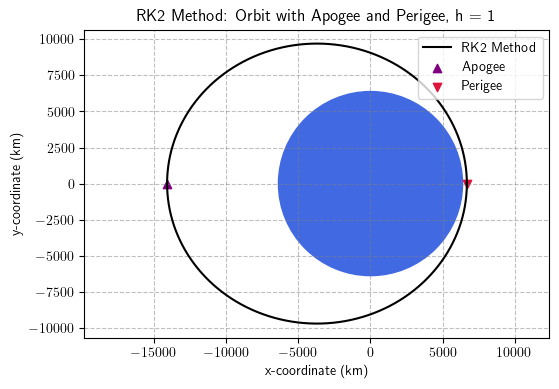

CPU times: user 199 ms, sys: 7.23 ms, total: 206 ms
Wall time: 216 ms


In [14]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(rk2_pos_x / 1000, rk2_pos_y / 1000, lw=1.5, label='RK2 Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(rk2_pos_x[rk2_apogee_idx] / 1000, rk2_pos_y[rk2_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(rk2_pos_x[rk2_perigee_idx] / 1000, rk2_pos_y[rk2_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK2 Method: Orbit with Apogee and Perigee, h = 1')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.axis('equal')
plt.savefig('RK2 Method: Orbit with Apogee and Perigee, h = 1.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [15]:
%%time
rk2_energy_loss, rk2_ang_mom_loss, rk2_initial_energy, rk2_final_energy, rk2_initial_ang_mom, rk2_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK2): {rk2_initial_energy:.4e}')
print(f'Final Total Energy (RK2): {rk2_final_energy:.4e}')
print(f'Percentage Energy Loss (RK2): {rk2_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK2): {rk2_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK2): {rk2_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK2): {rk2_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK2): -1.9187e+07
Final Total Energy (RK2): -1.9187e+07
Percentage Energy Loss (RK2): 1.3125e-07%
Initial Angular Momentum (RK2): 6.0102e+10
Final Angular Momentum (RK2): 6.0102e+10
Percentage Angular Momentum Loss (RK2): 2.1355e-08%

CPU times: user 232 µs, sys: 0 ns, total: 232 µs
Wall time: 224 µs


#### Simulation parameters

In [16]:
total_time = 10536  # simulation time for one orbit in seconds
time_step = 10      # time step 

#### Integration

In [17]:
%%time
rk2_time, rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y = rk2_orbit_solver(total_time, time_step)

CPU times: user 586 µs, sys: 0 ns, total: 586 µs
Wall time: 592 µs


#### Perigee Verification and Apogee Calculation

In [18]:
%%time
rk2_dist = calc_distance(rk2_pos_x, rk2_pos_y)

rk2_apogee_idx = np.argmax(rk2_dist)
rk2_perigee_idx = np.argmin(rk2_dist)

rk2_apogee = rk2_dist[rk2_apogee_idx] - radius_earth
rk2_perigee = rk2_dist[rk2_perigee_idx] - radius_earth

print(f'Apogee (RK2 Method): {rk2_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK2 Method): {rk2_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK2 Method): 7717.73 km above Earth's surface
Perigee (RK2 Method): 300.00 km above Earth's surface
CPU times: user 384 µs, sys: 0 ns, total: 384 µs
Wall time: 334 µs


#### Orbital Period Calculation

In [19]:
%%time
rk2_indx, rk2_indy = calculate_rk2_time_period(rk2_pos_x, rk2_pos_y, rk2_time)

print(f'The x-time period (RK2) is approximately {rk2_time[rk2_indx]:.2f} s with index {rk2_indx}')
print(f'The y-time period (RK2) is approximately {rk2_time[rk2_indy]:.2f} s with index {rk2_indy}')

The x-time period (RK2) is approximately 10.00 s with index 1
The y-time period (RK2) is approximately 5270.00 s with index 527
CPU times: user 226 µs, sys: 0 ns, total: 226 µs
Wall time: 207 µs


#### Plotting the Orbit

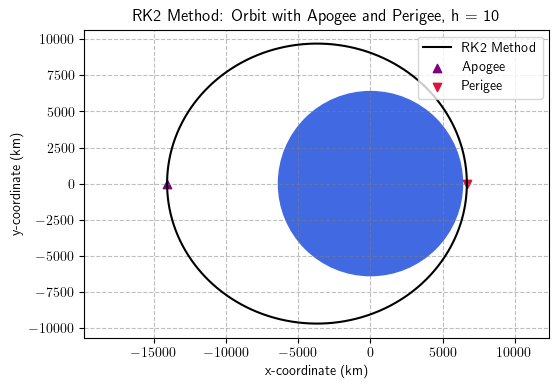

CPU times: user 195 ms, sys: 11.4 ms, total: 206 ms
Wall time: 217 ms


In [20]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(rk2_pos_x / 1000, rk2_pos_y / 1000, lw=1.5, label='RK2 Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(rk2_pos_x[rk2_apogee_idx] / 1000, rk2_pos_y[rk2_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(rk2_pos_x[rk2_perigee_idx] / 1000, rk2_pos_y[rk2_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK2 Method: Orbit with Apogee and Perigee, h = 10')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.axis('equal')
plt.savefig('RK2 Method: Orbit with Apogee and Perigee, h = 10.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [21]:
%%time
rk2_energy_loss, rk2_ang_mom_loss, rk2_initial_energy, rk2_final_energy, rk2_initial_ang_mom, rk2_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK2): {rk2_initial_energy:.4e}')
print(f'Final Total Energy (RK2): {rk2_final_energy:.4e}')
print(f'Percentage Energy Loss (RK2): {rk2_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK2): {rk2_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK2): {rk2_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK2): {rk2_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK2): -1.9187e+07
Final Total Energy (RK2): -1.9187e+07
Percentage Energy Loss (RK2): 1.2878e-04%
Initial Angular Momentum (RK2): 6.0102e+10
Final Angular Momentum (RK2): 6.0102e+10
Percentage Angular Momentum Loss (RK2): 2.0511e-05%

CPU times: user 285 µs, sys: 0 ns, total: 285 µs
Wall time: 265 µs


## For 10000 Orbits

#### Simulation parameters

In [4]:
total_time = 10536*10000  # simulation time for one orbit in seconds
time_step = 1           # time step (kernel is dying with h= 0.1)

#### Integration

In [5]:
%%time
rk2_time, rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y = rk2_orbit_solver(total_time, time_step)

CPU times: user 20.1 s, sys: 1.54 s, total: 21.6 s
Wall time: 21.6 s


#### Perigee Verification and Apogee Calculation

In [6]:
%%time
rk2_dist = calc_distance(rk2_pos_x, rk2_pos_y)

rk2_apogee_idx = np.argmax(rk2_dist)
rk2_perigee_idx = np.argmin(rk2_dist)

rk2_apogee = rk2_dist[rk2_apogee_idx] - radius_earth
rk2_perigee = rk2_dist[rk2_perigee_idx] - radius_earth

print(f'Apogee (RK2 Method): {rk2_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK2 Method): {rk2_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK2 Method): 7718.31 km above Earth's surface
Perigee (RK2 Method): 299.98 km above Earth's surface
CPU times: user 448 ms, sys: 252 ms, total: 700 ms
Wall time: 700 ms


#### Orbital Period Calculation

In [23]:
%%time
rk2_indx, rk2_indy = calculate_rk2_time_period(rk2_pos_x, rk2_pos_y, rk2_time)

print(f'The x-time period (RK2) is approximately {rk2_time[rk2_indx]:.2f} s with index {rk2_indx}')
print(f'The y-time period (RK2) is approximately {rk2_time[rk2_indy]:.2f} s with index {rk2_indy}')

The x-time period (RK2) is approximately 10.00 s with index 1
The y-time period (RK2) is approximately 5270.00 s with index 527
CPU times: user 59 µs, sys: 4 µs, total: 63 µs
Wall time: 64.4 µs


#### Plotting the Orbit

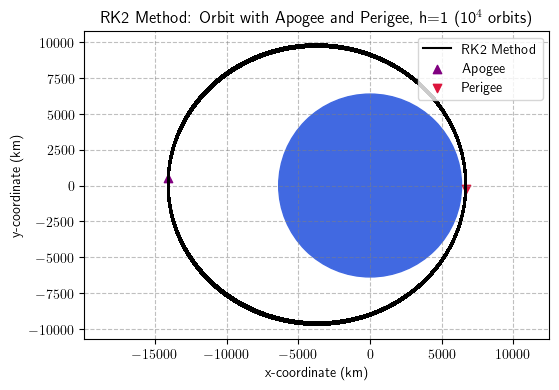

CPU times: user 7.36 s, sys: 468 ms, total: 7.83 s
Wall time: 8.14 s


In [7]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)

# Downsampling the position data (every 1000th point)
N = 100  # Downsampling factor

# Plotting the downsampled orbit
plt.plot(rk2_pos_x[::N] / 1000, rk2_pos_y[::N] / 1000, lw=1.5, label='RK2 Method', c='k')
# Adding the Earth representation
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
# Plotting apogee and perigee
plt.scatter(rk2_pos_x[rk2_apogee_idx] / 1000, rk2_pos_y[rk2_apogee_idx] / 1000, 
            c='purple', label='Apogee', marker="^")
plt.scatter(rk2_pos_x[rk2_perigee_idx] / 1000, rk2_pos_y[rk2_perigee_idx] / 1000, 
            c='crimson', label='Perigee', marker="v")
# Labels and title
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK2 Method: Orbit with Apogee and Perigee, h=1 (10$^4$ orbits)')
plt.axis('equal')
plt.savefig('RK2 Method: Orbit with Apogee and Perigee, h=1 (10$^4$ orbits).pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [26]:
%%time
rk2_energy_loss, rk2_ang_mom_loss, rk2_initial_energy, rk2_final_energy, rk2_initial_ang_mom, rk2_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK2): {rk2_initial_energy:.4e}')
print(f'Final Total Energy (RK2): {rk2_final_energy:.4e}')
print(f'Percentage Energy Loss (RK2): {rk2_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK2): {rk2_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK2): {rk2_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK2): {rk2_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK2): -1.9187e+07
Final Total Energy (RK2): -1.9187e+07
Percentage Energy Loss (RK2): 1.2878e-04%
Initial Angular Momentum (RK2): 6.0102e+10
Final Angular Momentum (RK2): 6.0102e+10
Percentage Angular Momentum Loss (RK2): 2.0511e-05%

CPU times: user 250 µs, sys: 17 µs, total: 267 µs
Wall time: 257 µs


#### Simulation parameters

In [4]:
total_time = 10536*10000  # simulation time for one orbit in seconds
time_step = 10           # time step (kernel is dying with h= 0.1)

#### Integration

In [5]:
%%time
rk2_time, rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y = rk2_orbit_solver(total_time, time_step)

CPU times: user 3.05 s, sys: 205 ms, total: 3.26 s
Wall time: 3.35 s


#### Perigee Verification and Apogee Calculation

In [6]:
%%time
rk2_dist = calc_distance(rk2_pos_x, rk2_pos_y)

rk2_apogee_idx = np.argmax(rk2_dist)
rk2_perigee_idx = np.argmin(rk2_dist)

rk2_apogee = rk2_dist[rk2_apogee_idx] - radius_earth
rk2_perigee = rk2_dist[rk2_perigee_idx] - radius_earth

print(f'Apogee (RK2 Method): {rk2_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK2 Method): {rk2_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK2 Method): 8019.86 km above Earth's surface
Perigee (RK2 Method): 275.23 km above Earth's surface
CPU times: user 224 ms, sys: 34 ms, total: 258 ms
Wall time: 259 ms


#### Orbital Period Calculation

In [32]:
%%time
rk2_indx, rk2_indy = calculate_rk2_time_period(rk2_pos_x, rk2_pos_y, rk2_time)

print(f'The x-time period (RK2) is approximately {rk2_time[rk2_indx]:.2f} s with index {rk2_indx}')
print(f'The y-time period (RK2) is approximately {rk2_time[rk2_indy]:.2f} s with index {rk2_indy}')

The x-time period (RK2) is approximately 242310.00 s with index 24231
The y-time period (RK2) is approximately 57660750.00 s with index 5766075
CPU times: user 200 ms, sys: 17 ms, total: 217 ms
Wall time: 217 ms


#### Plotting the Orbit

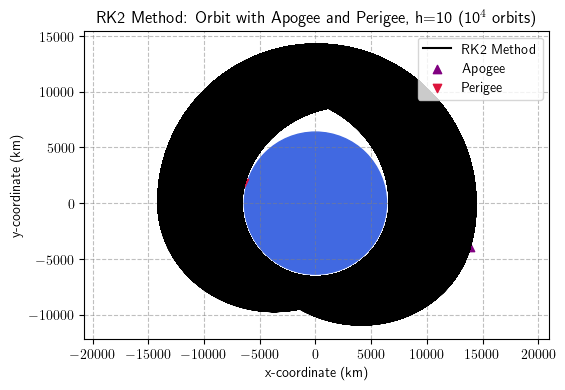

CPU times: user 6.1 s, sys: 381 ms, total: 6.48 s
Wall time: 6.74 s


In [7]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)

# Downsampling the position data (every 1000th point)
N = 10  # Downsampling factor

# Plotting the downsampled orbit
plt.plot(rk2_pos_x[::N] / 1000, rk2_pos_y[::N] / 1000, lw=1.5, label='RK2 Method', c='k')
# Adding the Earth representation
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
# Plotting apogee and perigee
plt.scatter(rk2_pos_x[rk2_apogee_idx] / 1000, rk2_pos_y[rk2_apogee_idx] / 1000, 
            c='purple', label='Apogee', marker="^")
plt.scatter(rk2_pos_x[rk2_perigee_idx] / 1000, rk2_pos_y[rk2_perigee_idx] / 1000, 
            c='crimson', label='Perigee', marker="v")
# Labels and title
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK2 Method: Orbit with Apogee and Perigee, h=10 (10$^4$ orbits)')
plt.axis('equal')
plt.savefig('RK2 Method: Orbit with Apogee and Perigee, h=10 (10$^4$ orbits).pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [34]:
%%time
rk2_energy_loss, rk2_ang_mom_loss, rk2_initial_energy, rk2_final_energy, rk2_initial_ang_mom, rk2_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk2_pos_x, rk2_pos_y, rk2_vel_x, rk2_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK2): {rk2_initial_energy:.4e}')
print(f'Final Total Energy (RK2): {rk2_final_energy:.4e}')
print(f'Percentage Energy Loss (RK2): {rk2_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK2): {rk2_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK2): {rk2_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK2): {rk2_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK2): -1.9187e+07
Final Total Energy (RK2): -1.8935e+07
Percentage Energy Loss (RK2): 1.3139e+00%
Initial Angular Momentum (RK2): 6.0102e+10
Final Angular Momentum (RK2): 6.0227e+10
Percentage Angular Momentum Loss (RK2): 2.0878e-01%

CPU times: user 110 ms, sys: 54.3 ms, total: 164 ms
Wall time: 163 ms


# RK4 Method

## For One Orbit

#### Simulation parameters

In [4]:
total_time = 10536  # simulation time for one orbit in seconds
time_step = 0.1     # time step

#### Integration

In [5]:
%%time
rk4_time, rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y = rk4_orbit_solver(total_time, time_step)

CPU times: user 780 ms, sys: 36.7 ms, total: 817 ms
Wall time: 820 ms


#### Perigee Verification and Apogee Calculation

In [6]:
%%time
rk4_dist = calc_distance(rk4_pos_x, rk4_pos_y)

rk4_apogee_idx = np.argmax(rk4_dist)
rk4_perigee_idx = np.argmin(rk4_dist)

rk4_apogee = rk4_dist[rk4_apogee_idx] - radius_earth
rk4_perigee = rk4_dist[rk4_perigee_idx] - radius_earth

print(f'Apogee (RK4 method): {rk4_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK4 method): {rk4_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK4 method): 7718.02 km above Earth's surface
Perigee (RK4 method): 300.00 km above Earth's surface
CPU times: user 118 ms, sys: 6.01 ms, total: 124 ms
Wall time: 124 ms


#### Orbital Period Calculation

In [7]:
%%time
rk4_indx, rk4_indy = calculate_rk4_time_period(rk4_pos_x, rk4_pos_y, rk4_time)

print(f'The x-time period (RK4) is approximately {rk4_time[rk4_indx]:.2f} s with index {rk4_indx}')
print(f'The y-time period (RK4) is approximately {rk4_time[rk4_indy]:.2f} s with index {rk4_indy}')

The x-time period (RK4) is approximately 10535.40 s with index 105354
The y-time period (RK4) is approximately 10535.40 s with index 105354
CPU times: user 367 ms, sys: 7.97 ms, total: 375 ms
Wall time: 374 ms


#### Plotting the Orbit

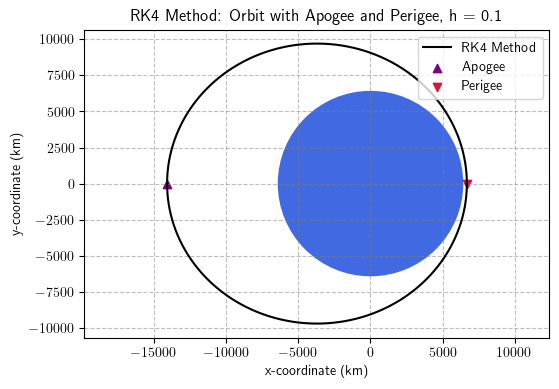

CPU times: user 358 ms, sys: 11.3 ms, total: 369 ms
Wall time: 452 ms


In [8]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(rk4_pos_x / 1000, rk4_pos_y / 1000, lw=1.5, label='RK4 Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(rk4_pos_x[rk4_apogee_idx] / 1000, rk4_pos_y[rk4_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(rk4_pos_x[rk4_perigee_idx] / 1000, rk4_pos_y[rk4_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK4 Method: Orbit with Apogee and Perigee, h = 0.1')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.axis('equal')
plt.savefig('RK4 Method: Orbit with Apogee and Perigee, h = 0.1.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [9]:
%%time
rk4_energy_loss, rk4_ang_mom_loss, rk4_initial_energy, rk4_final_energy, rk4_initial_ang_mom, rk4_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK4): {rk4_initial_energy:.4e}')
print(f'Final Total Energy (RK4): {rk4_final_energy:.4e}')
print(f'Percentage Energy Loss (RK4): {rk4_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK4): {rk4_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK4): {rk4_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK4): {rk4_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK4): -1.9187e+07
Final Total Energy (RK4): -1.9187e+07
Percentage Energy Loss (RK4): 5.8247e-13%
Initial Angular Momentum (RK4): 6.0102e+10
Final Angular Momentum (RK4): 6.0102e+10
Percentage Angular Momentum Loss (RK4): 8.2512e-13%

CPU times: user 494 ms, sys: 11.9 ms, total: 506 ms
Wall time: 507 ms


#### Simulation parameters

In [10]:
total_time = 10536  # simulation time for one orbit in seconds
time_step =  1     # time step

#### Integration

In [11]:
%%time
rk4_time, rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y = rk4_orbit_solver(total_time, time_step)

CPU times: user 317 ms, sys: 2 ms, total: 319 ms
Wall time: 318 ms


#### Perigee Verification and Apogee Calculation

In [12]:
%%time
rk4_dist = calc_distance(rk4_pos_x, rk4_pos_y)

rk4_apogee_idx = np.argmax(rk4_dist)
rk4_perigee_idx = np.argmin(rk4_dist)

rk4_apogee = rk4_dist[rk4_apogee_idx] - radius_earth
rk4_perigee = rk4_dist[rk4_perigee_idx] - radius_earth

print(f'Apogee (RK4 method): {rk4_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK4 method): {rk4_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK4 method): 7718.02 km above Earth's surface
Perigee (RK4 method): 300.00 km above Earth's surface
CPU times: user 411 µs, sys: 0 ns, total: 411 µs
Wall time: 408 µs


#### Orbital Period Calculation

In [13]:
%%time
rk4_indx, rk4_indy = calculate_rk4_time_period(rk4_pos_x, rk4_pos_y, rk4_time)

print(f'The x-time period (RK4) is approximately {rk4_time[rk4_indx]:.2f} s with index {rk4_indx}')
print(f'The y-time period (RK4) is approximately {rk4_time[rk4_indy]:.2f} s with index {rk4_indy}')

The x-time period (RK4) is approximately 10535.00 s with index 10535
The y-time period (RK4) is approximately 5268.00 s with index 5268
CPU times: user 360 µs, sys: 0 ns, total: 360 µs
Wall time: 337 µs


#### Plotting the Orbit

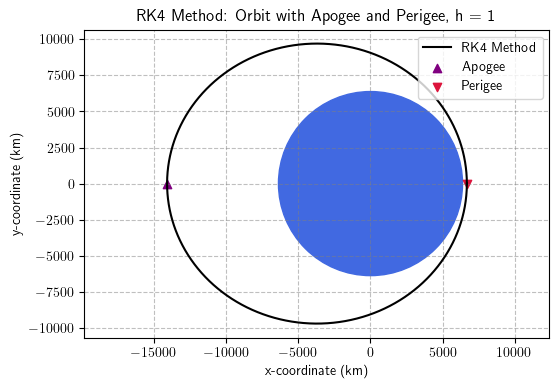

CPU times: user 207 ms, sys: 4.15 ms, total: 211 ms
Wall time: 218 ms


In [14]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(rk4_pos_x / 1000, rk4_pos_y / 1000, lw=1.5, label='RK4 Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(rk4_pos_x[rk4_apogee_idx] / 1000, rk4_pos_y[rk4_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(rk4_pos_x[rk4_perigee_idx] / 1000, rk4_pos_y[rk4_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK4 Method: Orbit with Apogee and Perigee, h = 1')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.axis('equal')
plt.savefig('RK4 Method: Orbit with Apogee and Perigee, h = 1.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [15]:
%%time
rk4_energy_loss, rk4_ang_mom_loss, rk4_initial_energy, rk4_final_energy, rk4_initial_ang_mom, rk4_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK4): {rk4_initial_energy:.4e}')
print(f'Final Total Energy (RK4): {rk4_final_energy:.4e}')
print(f'Percentage Energy Loss (RK4): {rk4_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK4): {rk4_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK4): {rk4_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK4): {rk4_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK4): -1.9187e+07
Final Total Energy (RK4): -1.9187e+07
Percentage Energy Loss (RK4): 1.0096e-12%
Initial Angular Momentum (RK4): 6.0102e+10
Final Angular Momentum (RK4): 6.0102e+10
Percentage Angular Momentum Loss (RK4): 5.9662e-13%

CPU times: user 499 µs, sys: 3 µs, total: 502 µs
Wall time: 473 µs


#### Simulation parameters

In [16]:
total_time = 10536  # simulation time for one orbit in seconds
time_step =  10     # time step

#### Integration

In [17]:
%%time
rk4_time, rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y = rk4_orbit_solver(total_time, time_step)

CPU times: user 553 µs, sys: 0 ns, total: 553 µs
Wall time: 557 µs


#### Perigee Verification and Apogee Calculation

In [18]:
%%time
rk4_dist = calc_distance(rk4_pos_x, rk4_pos_y)

rk4_apogee_idx = np.argmax(rk4_dist)
rk4_perigee_idx = np.argmin(rk4_dist)

rk4_apogee = rk4_dist[rk4_apogee_idx] - radius_earth
rk4_perigee = rk4_dist[rk4_perigee_idx] - radius_earth

print(f'Apogee (RK4 method): {rk4_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK4 method): {rk4_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK4 method): 7718.01 km above Earth's surface
Perigee (RK4 method): 300.00 km above Earth's surface
CPU times: user 194 µs, sys: 9 µs, total: 203 µs
Wall time: 263 µs


#### Orbital Period Calculation

In [19]:
%%time
rk4_indx, rk4_indy = calculate_rk4_time_period(rk4_pos_x, rk4_pos_y, rk4_time)

print(f'The x-time period (RK4) is approximately {rk4_time[rk4_indx]:.2f} s with index {rk4_indx}')
print(f'The y-time period (RK4) is approximately {rk4_time[rk4_indy]:.2f} s with index {rk4_indy}')

The x-time period (RK4) is approximately 10.00 s with index 1
The y-time period (RK4) is approximately 5270.00 s with index 527
CPU times: user 79 µs, sys: 4 µs, total: 83 µs
Wall time: 77.7 µs


#### Plotting the Orbit

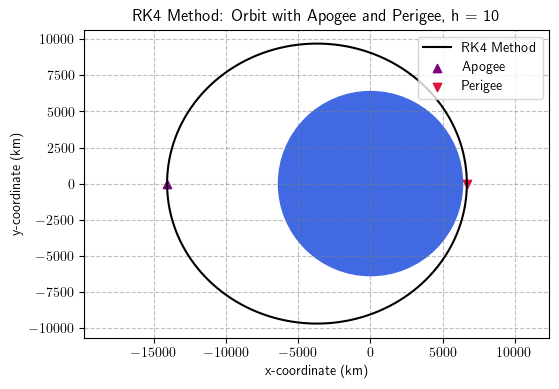

CPU times: user 204 ms, sys: 5.77 ms, total: 210 ms
Wall time: 218 ms


In [20]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(rk4_pos_x / 1000, rk4_pos_y / 1000, lw=1.5, label='RK4 Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(rk4_pos_x[rk4_apogee_idx] / 1000, rk4_pos_y[rk4_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(rk4_pos_x[rk4_perigee_idx] / 1000, rk4_pos_y[rk4_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK4 Method: Orbit with Apogee and Perigee, h = 10')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.axis('equal')
plt.savefig('RK4 Method: Orbit with Apogee and Perigee, h = 10.pdf')
plt.show()

#### Energy & Angular Momentum Loss

In [21]:
%%time
rk4_energy_loss, rk4_ang_mom_loss, rk4_initial_energy, rk4_final_energy, rk4_initial_ang_mom, rk4_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK4): {rk4_initial_energy:.4e}')
print(f'Final Total Energy (RK4): {rk4_final_energy:.4e}')
print(f'Percentage Energy Loss (RK4): {rk4_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK4): {rk4_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK4): {rk4_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK4): {rk4_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK4): -1.9187e+07
Final Total Energy (RK4): -1.9187e+07
Percentage Energy Loss (RK4): 2.4760e-09%
Initial Angular Momentum (RK4): 6.0102e+10
Final Angular Momentum (RK4): 6.0102e+10
Percentage Angular Momentum Loss (RK4): 5.8068e-10%

CPU times: user 287 µs, sys: 0 ns, total: 287 µs
Wall time: 273 µs


## For 10000 Orbits

#### Simulation parameters

In [22]:
total_time = 10536*10000  # simulation time for one orbit in seconds
time_step = 10            # time step (kernel is dying with h= 0.1 & 1)

#### Integration

In [23]:
%%time
rk4_time, rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y = rk4_orbit_solver(total_time, time_step)

CPU times: user 3.09 s, sys: 112 ms, total: 3.2 s
Wall time: 3.16 s


#### Perigee Verification and Apogee Calculation

In [24]:
%%time
rk4_dist = calc_distance(rk4_pos_x, rk4_pos_y)

rk4_apogee_idx = np.argmax(rk4_dist)
rk4_perigee_idx = np.argmin(rk4_dist)

rk4_apogee = rk4_dist[rk4_apogee_idx] - radius_earth
rk4_perigee = rk4_dist[rk4_perigee_idx] - radius_earth

print(f'Apogee (RK4 method): {rk4_apogee / 1000:.2f} km above Earth\'s surface')
print(f'Perigee (RK4 method): {rk4_perigee / 1000:.2f} km above Earth\'s surface')

Apogee (RK4 method): 7718.02 km above Earth's surface
Perigee (RK4 method): 300.00 km above Earth's surface
CPU times: user 31.6 ms, sys: 17.1 ms, total: 48.7 ms
Wall time: 47.5 ms


#### Orbital Period Calculation

In [25]:
%%time
rk4_indx, rk4_indy = calculate_rk4_time_period(rk4_pos_x, rk4_pos_y, rk4_time)

print(f'The x-time period (RK4) is approximately {rk4_time[rk4_indx]:.2f} s with index {rk4_indx}')
print(f'The y-time period (RK4) is approximately {rk4_time[rk4_indy]:.2f} s with index {rk4_indy}')

The x-time period (RK4) is approximately 26096290.00 s with index 2609629
The y-time period (RK4) is approximately 98069150.00 s with index 9806915
CPU times: user 38 ms, sys: 59.3 ms, total: 97.3 ms
Wall time: 96.9 ms


#### Plotting the Orbit

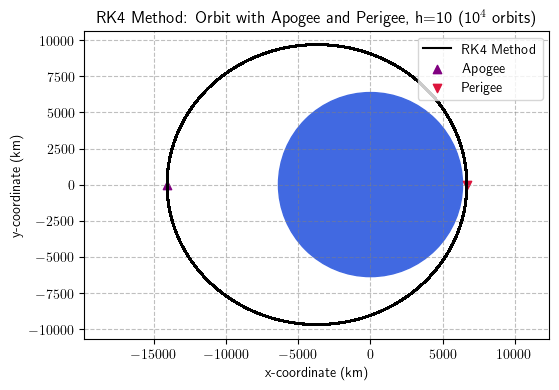

CPU times: user 8.5 s, sys: 595 ms, total: 9.1 s
Wall time: 9.09 s


In [26]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(rk4_pos_x / 1000, rk4_pos_y / 1000, lw=1.5, label='RK4 Method', c='k')
earth_circle = plt.Circle((0, 0), radius_earth / 1000, color='royalblue', fill=True)
ax.add_artist(earth_circle)
plt.scatter(rk4_pos_x[rk4_apogee_idx] / 1000, rk4_pos_y[rk4_apogee_idx] / 1000, c='purple', label='Apogee', marker="^")
plt.scatter(rk4_pos_x[rk4_perigee_idx] / 1000, rk4_pos_y[rk4_perigee_idx] / 1000, c='crimson', label='Perigee', marker="v")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.legend(loc='upper right')
plt.title('RK4 Method: Orbit with Apogee and Perigee, h=10 (10$^4$ orbits)')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.axis('equal')
plt.savefig('RK4 Method: Orbit with Apogee and Perigee, h=10 (10$^4$ orbits).png', dpi=300)
plt.show()

#### Energy & Angular Momentum Loss

In [27]:
%%time
rk4_energy_loss, rk4_ang_mom_loss, rk4_initial_energy, rk4_final_energy, rk4_initial_ang_mom, rk4_final_ang_mom = energy_and_angular_momentum_loss_calc(
    rk4_pos_x, rk4_pos_y, rk4_vel_x, rk4_vel_y
)

# Printing initial, final, and percentage changes for energy and angular momentum
print(f'Initial Total Energy (RK4): {rk4_initial_energy:.4e}')
print(f'Final Total Energy (RK4): {rk4_final_energy:.4e}')
print(f'Percentage Energy Loss (RK4): {rk4_energy_loss[-1]:.4e}%')

print(f'Initial Angular Momentum (RK4): {rk4_initial_ang_mom:.4e}')
print(f'Final Angular Momentum (RK4): {rk4_final_ang_mom:.4e}')
print(f'Percentage Angular Momentum Loss (RK4): {rk4_ang_mom_loss[-1]:.4e}%\n')

Initial Total Energy (RK4): -1.9187e+07
Final Total Energy (RK4): -1.9187e+07
Percentage Energy Loss (RK4): 2.4940e-05%
Initial Angular Momentum (RK4): 6.0102e+10
Final Angular Momentum (RK4): 6.0102e+10
Percentage Angular Momentum Loss (RK4): 5.8716e-06%

CPU times: user 102 ms, sys: 1.99 ms, total: 104 ms
Wall time: 103 ms


## Energy & Angular Momentum Loss Comparison after 10000 orbits

<>:10: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:10: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_41095/859825954.py:10: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Percentage Loss ($\%$)')
/tmp/ipykernel_41095/859825954.py:23: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Percentage Loss ($\%$)')


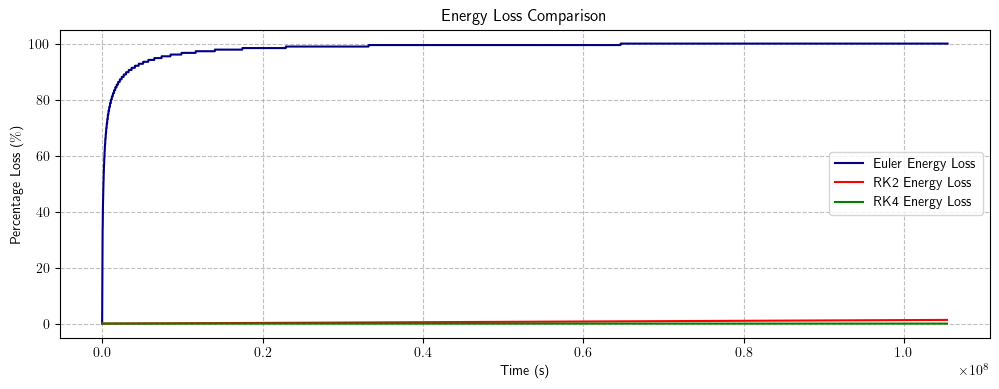

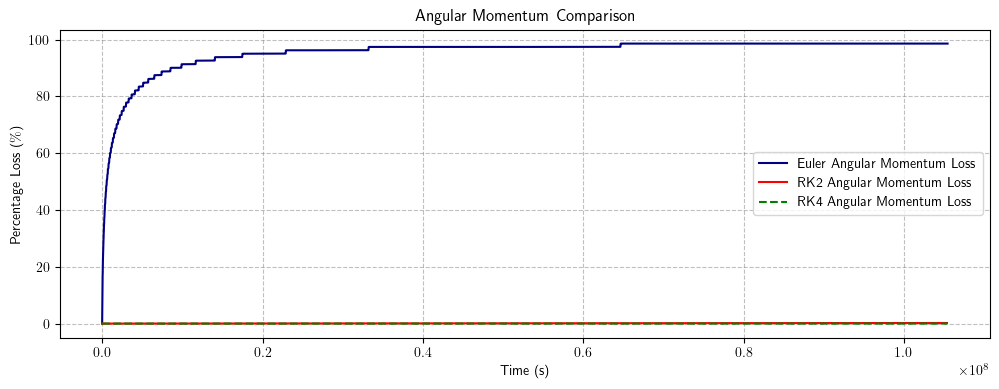

In [40]:
# Downsampling the data (every 1000th point)
N = 1000  # Downsampling factor

# Plotting energy loss for both methods
plt.figure(figsize=(12,4))
plt.plot(euler_time[::N], euler_energy_loss[::N], c='navy', label='Euler Energy Loss')
plt.plot(rk2_time[::N], rk2_energy_loss[::N], c='r', label='RK2 Energy Loss')
plt.plot(rk4_time[::N], rk4_energy_loss[::N], c='g', label='RK4 Energy Loss')
plt.xlabel('Time (s)')
plt.ylabel('Percentage Loss ($\%$)')
plt.legend()
plt.title('Energy Loss Comparison')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.savefig('Energy Loss Comparison.pdf')
plt.show()

# Plotting angular momentum loss for both methods
plt.figure(figsize=(12,4))
plt.plot(euler_time[::N], euler_ang_mom_loss[::N], c='navy', linestyle='-', label='Euler Angular Momentum Loss')
plt.plot(rk2_time[::N], rk2_ang_mom_loss[::N], c='red', linestyle='-', label='RK2 Angular Momentum Loss')
plt.plot(rk4_time[::N], rk4_ang_mom_loss[::N], c='g', linestyle='--', label='RK4 Angular Momentum Loss')
plt.xlabel('Time (s)')
plt.ylabel('Percentage Loss ($\%$)')
plt.legend()
plt.title('Angular Momentum Comparison')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.savefig('Angular Momentum Comparison.pdf')
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:21: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:21: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_41095/3552237822.py:9: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Percentage Loss ($\%$)')
/tmp/ipykernel_41095/3552237822.py:21: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Percentage Loss ($\%$)')


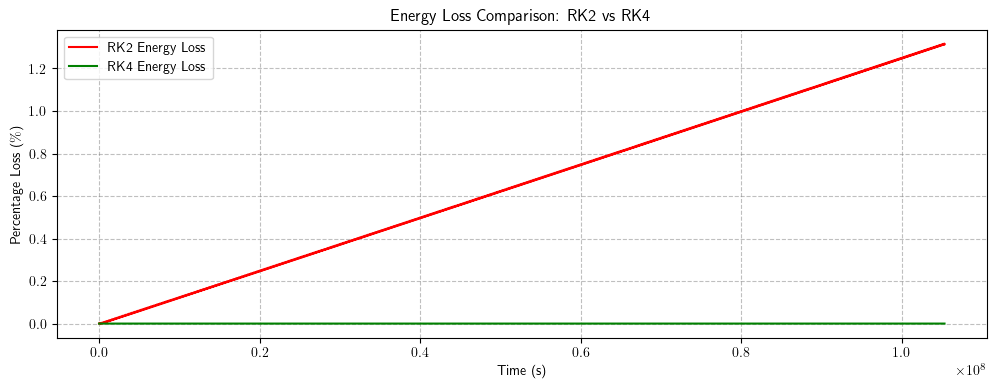

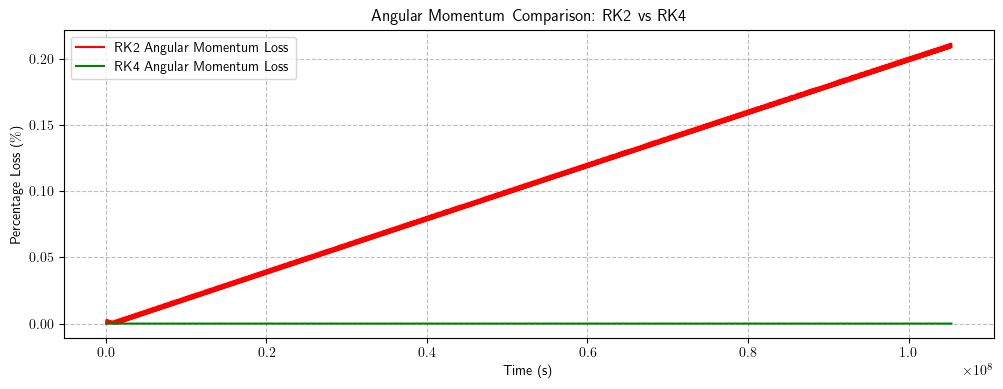

In [39]:
# Downsampling the data (every 1000th point)
N = 1000  # Downsampling factor

# Plotting energy loss for both methods
plt.figure(figsize=(12,4))
plt.plot(rk2_time[::N], rk2_energy_loss[::N], c='r', label='RK2 Energy Loss')
plt.plot(rk4_time[::N], rk4_energy_loss[::N], c='g', label='RK4 Energy Loss')
plt.xlabel('Time (s)')
plt.ylabel('Percentage Loss ($\%$)')
plt.legend()
plt.title('Energy Loss Comparison: RK2 vs RK4')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.savefig('Energy Loss Comparison: RK2 vs RK4.pdf')
plt.show()

# Plotting angular momentum loss for both methods
plt.figure(figsize=(12,4))
plt.plot(rk2_time[::N], rk2_ang_mom_loss[::N], c='red', linestyle='-', label='RK2 Angular Momentum Loss')
plt.plot(rk4_time[::N], rk4_ang_mom_loss[::N], c='g', linestyle='-', label='RK4 Angular Momentum Loss')
plt.xlabel('Time (s)')
plt.ylabel('Percentage Loss ($\%$)')
plt.legend()
plt.title('Angular Momentum Comparison: RK2 vs RK4')
plt.grid(True, which='both', linestyle='--', color='grey', alpha=0.5, zorder=0)
plt.savefig('Angular Momentum Comparison: RK2 vs RK4.pdf')
plt.show()